## Prepare Notebook

In [1]:
import aesara.tensor as aet
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

## Read Data

In [2]:
data_path = "https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv"

raw_data_df = pd.read_csv(data_path)

raw_data_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


## Data Formatting

In [3]:
data_df = raw_data_df \
    .copy() \
    .assign(
        date = pd.date_range(
            start=pd.to_datetime("2011-01-01"),
            end=pd.to_datetime("2012-12-31"), freq="D"
        )
    )

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   season           731 non-null    object        
 1   yr               731 non-null    int64         
 2   mnth             731 non-null    object        
 3   holiday          731 non-null    object        
 4   weekday          731 non-null    object        
 5   workingday       731 non-null    object        
 6   weathersit       731 non-null    object        
 7   temp             731 non-null    float64       
 8   hum              731 non-null    float64       
 9   windspeed        731 non-null    float64       
 10  cnt              731 non-null    int64         
 11  days_since_2011  731 non-null    int64         
 12  date             731 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 74.4+ KB


In [4]:
endog_scaler = StandardScaler()
exog_scaler = StandardScaler()

data_df["cnt_scaled"] = endog_scaler.fit_transform(X=data_df[["cnt"]])
data_df[["temp_scaled", "hum_scaled", "windspeed_scaled"]] = exog_scaler.fit_transform(
    X=data_df[["temp", "hum", "windspeed"]]
)

In [5]:
n = data_df.shape[0]

date = data_df["date"].to_numpy()

cnt_scaled = data_df["cnt_scaled"].to_numpy()

temp_scaled = data_df["temp_scaled"].to_numpy()
hum_scaled = data_df["hum_scaled"].to_numpy()
windspeed_scaled = data_df["windspeed_scaled"].to_numpy()
holiday_idx, holiday = data_df["holiday"].factorize(sort=True)
workingday_idx, workingday = data_df["workingday"].factorize(sort=True)
weathersit_idx, weathersit = data_df["weathersit"].factorize(sort=True)
t = data_df["days_since_2011"].to_numpy() / data_df["days_since_2011"].max()

n_order = 10
periods = data_df["date"].dt.dayofyear / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

## Base Model

In [6]:
coords = {
    "date": date,
    "holiday": holiday,
    "workingday": workingday,
    "weathersit": weathersit,
}

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(


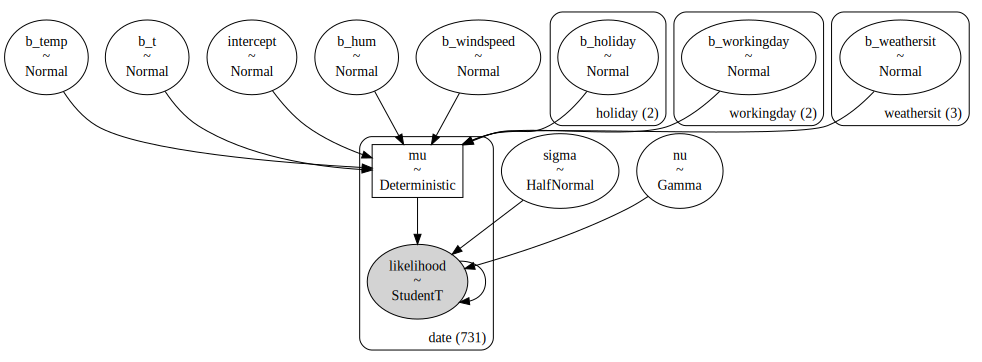

In [7]:
with pm.Model(coords=coords) as base_model:

    # --- priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    b_temp = pm.Normal(name="b_temp", mu=0, sigma=2)
    b_hum = pm.Normal(name="b_hum", mu=0, sigma=2)
    b_windspeed = pm.Normal(name="b_windspeed", mu=0, sigma=2)
    b_holiday = pm.Normal(name="b_holiday", mu=0, sigma=2, dims="holiday")
    b_workingday = pm.Normal(name="b_workingday", mu=0, sigma=2, dims="workingday")
    b_weathersit = pm.Normal(name="b_weathersit", mu=0, sigma=2, dims="weathersit")
    b_t = pm.Normal(name="b_t", mu=0, sigma=3)
    nu = pm.Gamma(name="nu", alpha=8, beta=2)
    sigma = pm.HalfNormal(name="sigma", sigma=2)

    # --- model parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=(
            intercept
            + b_t * t
            + b_temp * temp_scaled
            + b_hum * hum_scaled
            + b_windspeed * windspeed_scaled
            + b_holiday[holiday_idx]
            + b_workingday[workingday_idx]
            + b_weathersit[weathersit_idx]
        ),
        dims="date",
    )

    # --- likelihood ---
    likelihood = pm.StudentT(
        name="likelihood", mu=mu, nu=nu, sigma=sigma, dims="date", observed=cnt_scaled
    )

    # --- prior samples ---
    base_model_prior_predictive = pm.sample_prior_predictive(samples=200)

pm.model_to_graphviz(base_model)


<AxesSubplot:>

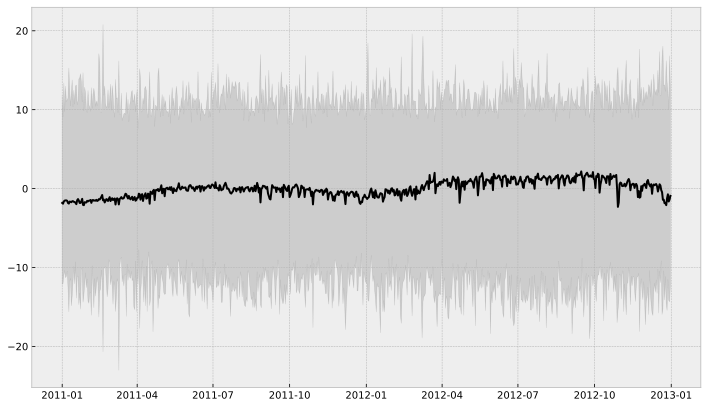

In [8]:
prior_likelihood_hdi = az.hdi(
    ary=base_model_prior_predictive["prior_predictive"]
)["likelihood"].to_numpy()

fig, ax = plt.subplots()
ax.fill_between(
    x=date,
    y1=prior_likelihood_hdi[:, 0],
    y2=prior_likelihood_hdi[:, 1],
    color="gray",
    alpha=0.3
)
sns.lineplot(x=date, y=cnt_scaled, color="black", ax=ax)

In [9]:
with base_model:
    base_model_trace = pm.sample(
        tune=1000, draws=3000, chains=4, return_inferencedata=True
    )
    base_model_posterior_predictive = pm.sample_posterior_predictive(
        trace=base_model_trace,
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, b_temp, b_hum, b_windspeed, b_holiday, b_workingday, b_weathersit, b_t, nu, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 748 seconds.


In [10]:
az.summary(data=base_model_trace, var_names=["~mu"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.576,1.509,-3.366,2.290,0.017,0.014,7713.0,7607.0,1.0
b_temp,0.512,0.017,0.482,0.545,0.000,0.000,11936.0,8166.0,1.0
b_hum,-0.112,0.022,-0.154,-0.073,0.000,0.000,11252.0,9256.0,1.0
b_windspeed,-0.097,0.018,-0.131,-0.065,0.000,0.000,11300.0,9522.0,1.0
b_holiday[NO HOLIDAY],-0.172,1.263,-2.660,2.081,0.014,0.012,7927.0,7997.0,1.0
b_holiday[HOLIDAY],-0.422,1.265,-2.811,1.925,0.014,0.012,7910.0,7986.0,1.0
b_workingday[NO WORKING DAY],-0.350,1.242,-2.616,2.035,0.015,0.013,6446.0,6878.0,1.0
b_workingday[WORKING DAY],-0.307,1.242,-2.595,2.057,0.015,0.013,6449.0,6769.0,1.0
b_weathersit[MISTY],0.022,1.060,-1.917,2.093,0.014,0.011,5383.0,6224.0,1.0
b_weathersit[GOOD],0.205,1.061,-1.783,2.219,0.014,0.011,5396.0,6257.0,1.0


In [11]:
axes = az.plot_trace(
    data=base_model_trace,
    var_names=["~mu"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Base Model - Trace")


Text(0.5, 0.98, 'Base Model - Trace')

Text(0.5, 0.98, 'Base Model - Posterior Distributions')

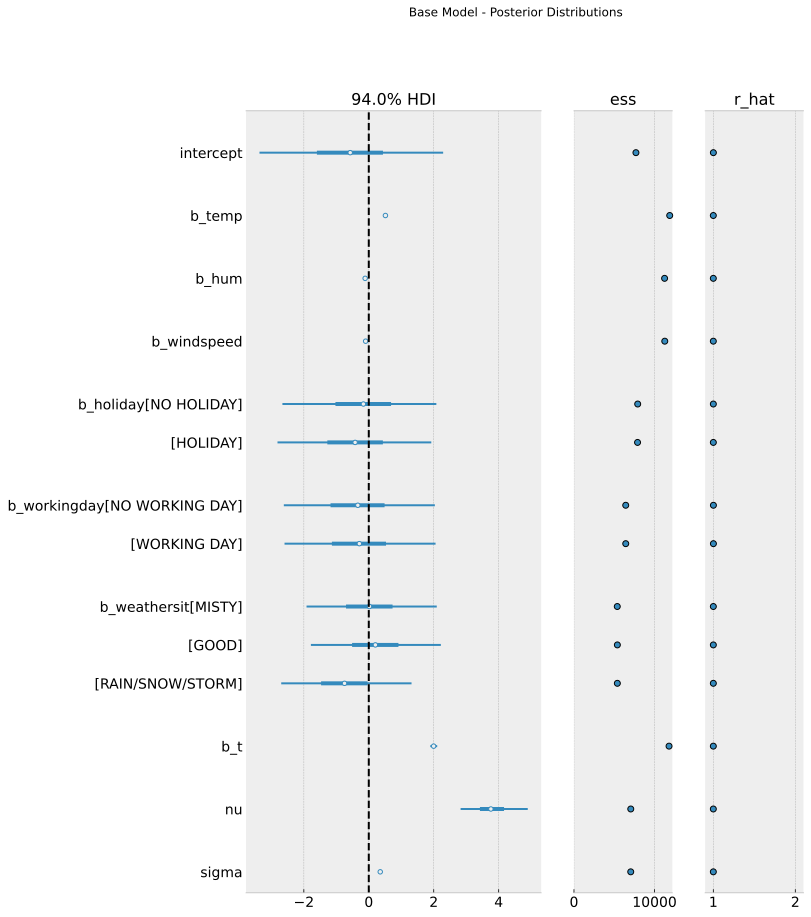

In [12]:
axes = az.plot_forest(
    data=base_model_trace,
    var_names=["~mu"],
    combined=True,
    r_hat=True,
    ess=True,
)
axes[0].axvline(x=0.0, color="black", linestyle="--")
plt.gcf().suptitle("Base Model - Posterior Distributions")


<AxesSubplot:ylabel='likelihood'>

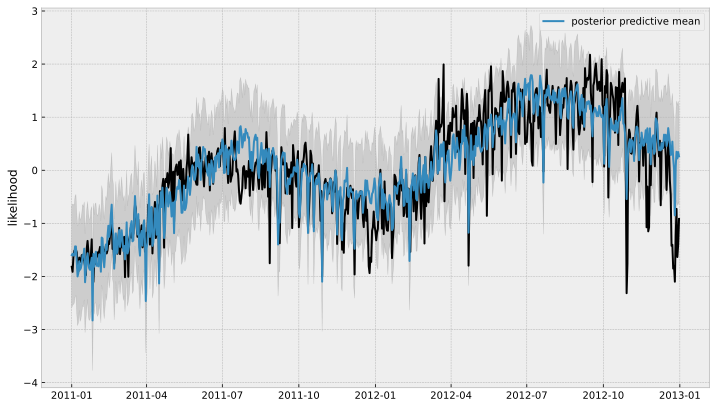

In [13]:
prior_likelihood_hdi = az.hdi(
    ary=base_model_posterior_predictive["posterior_predictive"]
)["likelihood"].to_numpy()

fig, ax = plt.subplots()
sns.lineplot(x=date, y=cnt_scaled, color="black", ax=ax)
ax.fill_between(
    x=date,
    y1=prior_likelihood_hdi[:, 0],
    y2=prior_likelihood_hdi[:, 1],
    color="gray",
    alpha=0.3,
)
sns.lineplot(
    x=date,
    y=(
        base_model_posterior_predictive["posterior_predictive"]["likelihood"]
        .stack(samples=("chain", "draw"))
        .mean(axis=1)
    ),
    color="C0",
    label="posterior predictive mean",
    ax=ax
)


## Time-Varying Coefficients Model

In [ ]:
with pm.Model(coords=coords) as model:

    # --- priors ---
    intercept = pm.Normal(name="intercept", mu=2_000, sigma=1_000)
    sigma_slope_temp = pm.HalfNormal("sigma_slope_temp", sigma=1)
    b_temp = pm.Normal(name="b_temp", mu=100, sigma=20)
    b_hum = pm.Normal(name="b_hum", mu=10, sigma=2)
    b_windspeed = pm.Normal(name="b_windspeed", mu=10, sigma=2)
    b_holiday = pm.Normal(name="b_holiday", mu=100, sigma=20, dims="holiday")
    b_workingday = pm.Normal(name="b_workingday", mu=100, sigma=20, dims="workingday")
    b_weathersit = pm.Normal(name="b_weathersit", mu=100, sigma=20, dims="weathersit")
    # ls = pm.Gamma(name="ls", alpha=100_000, beta=1_000)
    # eta = pm.HalfNormal("eta", sigma=1_000)
    # cov = eta *  pm.gp.cov.ExpQuad(input_dim=1, ls=ls) + pm.gp.cov.WhiteNoise(sigma=1_000)
    # gp = pm.gp.Latent(cov_func=cov)
    # f = gp.prior(name="f", X=t[..., None])
    sigma = pm.HalfNormal(name="sigma", sigma=2_000)

    # --- model parametrization ---
    mu_categorical = pm.Deterministic(
        name="mu_categorical",
        var=(
            b_holiday[holiday_idx]
            + b_workingday[workingday_idx]
            + b_weathersit[weathersit_idx]
        ),
        dims="date",
    )

    slopes_temp = pm.GaussianRandomWalk(
        name="slopes", sigma=sigma_slope_temp, shape=n
    )

    mu_continuous = pm.Deterministic(
        name="mu_continuous",
        var=(b_temp * temp + b_hum * hum + b_windspeed * windspeed),
        dims="date",
    )
    mu = pm.Deterministic(
        name="mu", var=(intercept + mu_continuous + mu_categorical), dims="date"
    )

    # --- likelihood ---
    likelihood = pm.Normal(
        name="likelihood", mu=mu, sigma=sigma, dims="date", observed=cnt
    )

    # --- prior samples ---
    model_prior_predictive = pm.sample_prior_predictive(samples=100)

pm.model_to_graphviz(model)


In [ ]:
prior_likelihood_hdi = az.hdi(
    ary=model_prior_predictive["prior_predictive"]
)["likelihood"].to_numpy()

fig, ax = plt.subplots()
ax.fill_between(
    x=date,
    y1=prior_likelihood_hdi[:, 0],
    y2=prior_likelihood_hdi[:, 1],
    color="gray",
    alpha=0.3
)
sns.lineplot(x=date, y=cnt, color="black", ax=ax)

In [ ]:
with model:
    model_trace = pm.sample(tune=1000, draws=3000, chains=4, return_inferencedata=True)
    model_posterior_predictive = pm.sample_posterior_predictive(trace=model_trace)
